# Imports

In [63]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

# Pre-processing of training and testing

In [ ]:
#  Utility Functions
def ensure(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def to_float(u8: np.ndarray) -> np.ndarray:
    return u8.astype(np.float32) / 255.0

def to_uint8(f32: np.ndarray) -> np.ndarray:
    return np.clip(f32 * 255.0, 0, 255).astype(np.uint8)

# Mask & Crop/Patch Functions
def extract_circular_mask(img_bgr: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        (x, y), r = cv2.minEnclosingCircle(cnt)
        cv2.circle(mask, (int(x), int(y)), int(r), 255, -1)
    return mask


def crop_pad_square(img: np.ndarray, mask_bin: np.ndarray) -> np.ndarray:
    ys, xs = np.where(mask_bin)
    if ys.size == 0 or xs.size == 0:
        return img  # fallback
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    crop = img[y0:y1+1, x0:x1+1]
    h, w = crop.shape[:2]
    d = max(h, w)
    pad_t = (d - h) // 2
    pad_b = d - h - pad_t
    pad_l = (d - w) // 2
    pad_r = d - w - pad_l
    if img.ndim == 2:
        border_val = 0
    else:
        border_val = [0,0,0]
    return cv2.copyMakeBorder(crop, pad_t, pad_b, pad_l, pad_r, cv2.BORDER_CONSTANT, value=border_val)

# Preprocessing Steps
def clahe_rgb_float(img_f: np.ndarray) -> np.ndarray:
    img_u = to_uint8(img_f)
    lab = cv2.cvtColor(img_u, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=(CLAHE_GRID, CLAHE_GRID))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    out_u = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return to_float(out_u)


def shade_correct_gauss(img_f: np.ndarray, mask_bin: np.ndarray) -> np.ndarray:
    blur = cv2.GaussianBlur(img_f, (0, 0), GAUSS_SIGMA)
    flat = img_f - blur
    # rescale only inside mask
    flat_masked = np.zeros_like(flat)
    m = mask_bin.astype(bool)
    if m.any():
        lo, hi = flat[m].min(), flat[m].max()
        flat_masked[m] = (flat[m] - lo) / (hi - lo + 1e-6)
    return np.clip(flat_masked, 0, 1)

In [ ]:
def show_sample_pipeline(img_path: Path, rim_width: int = 55):
    img_bgr = cv2.imread(str(img_path))
    mask = extract_circular_mask(img_bgr)

    # 1. Mask outside FOV
    img_f = to_float(img_bgr)
    img_f[~mask.astype(bool)] = 0.0

    # 2. CLAHE
    img_f_clahe = clahe_rgb_float(img_f)

    # 3. Shading Correction
    img_f_shade = shade_correct_gauss(img_f_clahe, mask)

    # 3.5 Edge Correction via Ring Darkening
    # Create a narrow ring at the fundus edge and darken it + Erode mask to get inner region
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2* rim_width + 1, 2* rim_width + 1))
    inner = cv2.erode(mask, kern)
    # ring pixels: in mask but not in inner
    ring = (mask.astype(bool) & ~inner.astype(bool))
    img_f_edge = img_f_shade.copy()
    # darken ring region by scaling down intensity
    img_f_edge[ring] *= 0.  # adjust (0.0 black - 1.0 unchanged)

    # 4. Crop & Pad
    img_crop = crop_pad_square(img_f_edge, mask)
    mask_crop = crop_pad_square(mask, mask)

    # 5. Resize
    final = cv2.resize(img_crop, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_AREA)
    mask_final = cv2.resize(mask_crop, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_NEAREST)

    # display
    orig_disp   = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    mask_disp   = mask
    masked_disp = orig_disp * (mask[..., None] / 255.0)
    clahe_disp  = cv2.cvtColor(to_uint8(img_f_clahe), cv2.COLOR_BGR2RGB)
    shade_disp  = cv2.cvtColor(to_uint8(img_f_shade), cv2.COLOR_BGR2RGB)
    edge_disp   = cv2.cvtColor(to_uint8(img_f_edge), cv2.COLOR_BGR2RGB)
    final_disp  = cv2.cvtColor(to_uint8(final), cv2.COLOR_BGR2RGB)
    final_disp[mask_final == 0] = 0

    # Plot
    fig, axs = plt.subplots(1, 7, figsize=(28, 5))
    titles = ['Original', 'Mask', 'Masked', 'CLAHE', 'Shade', 'EdgeCorr', 'Final']
    images = [orig_disp, mask_disp, masked_disp, clahe_disp, shade_disp, edge_disp, final_disp]
    for ax, img, t in zip(axs, images, titles):
        if img.ndim == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img.astype(np.uint8))
        ax.set_title(t)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Visualizing samples for Training Set


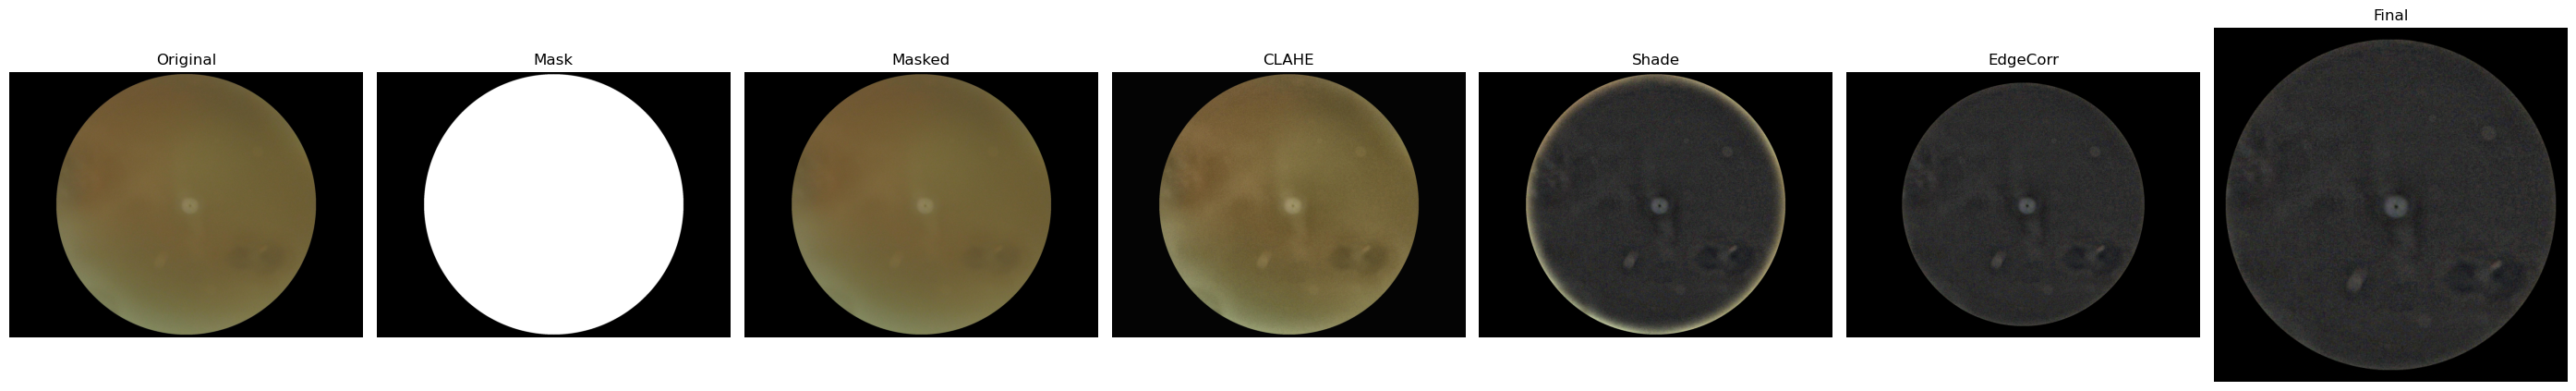

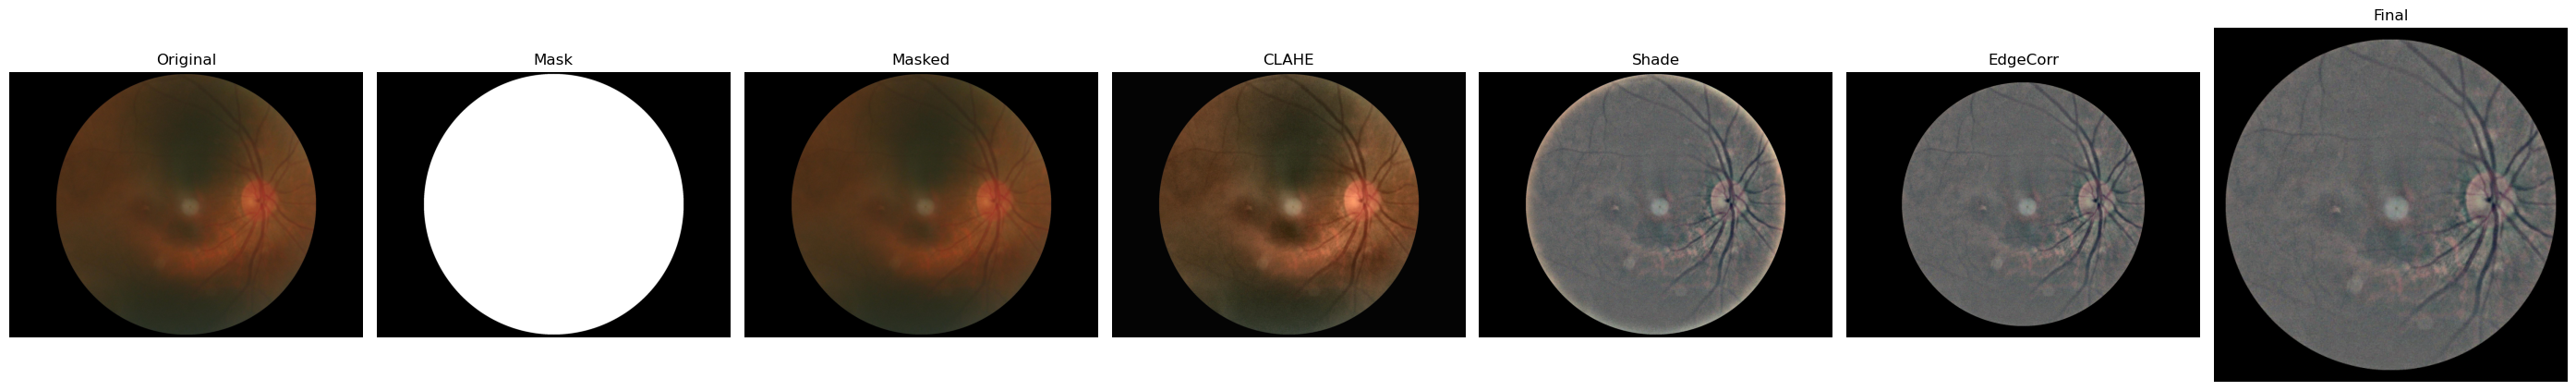

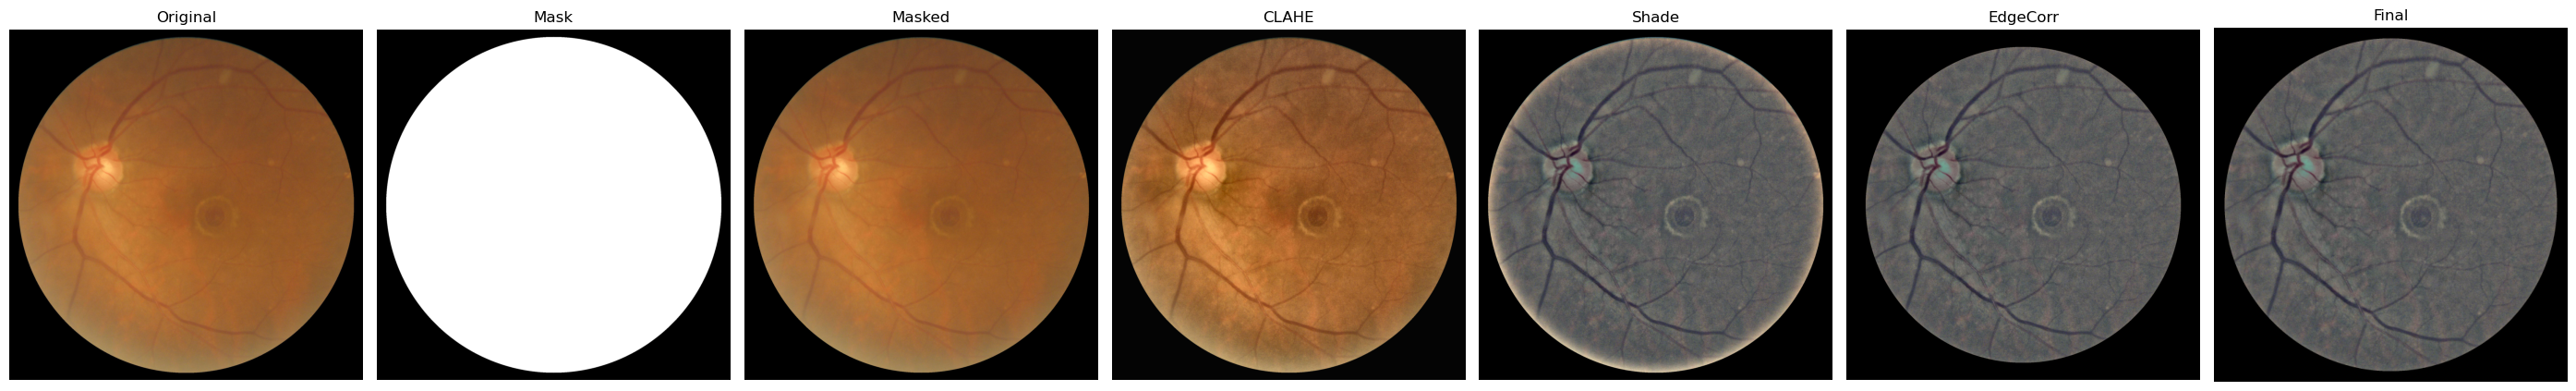

Visualizing samples for Off-site Test Set


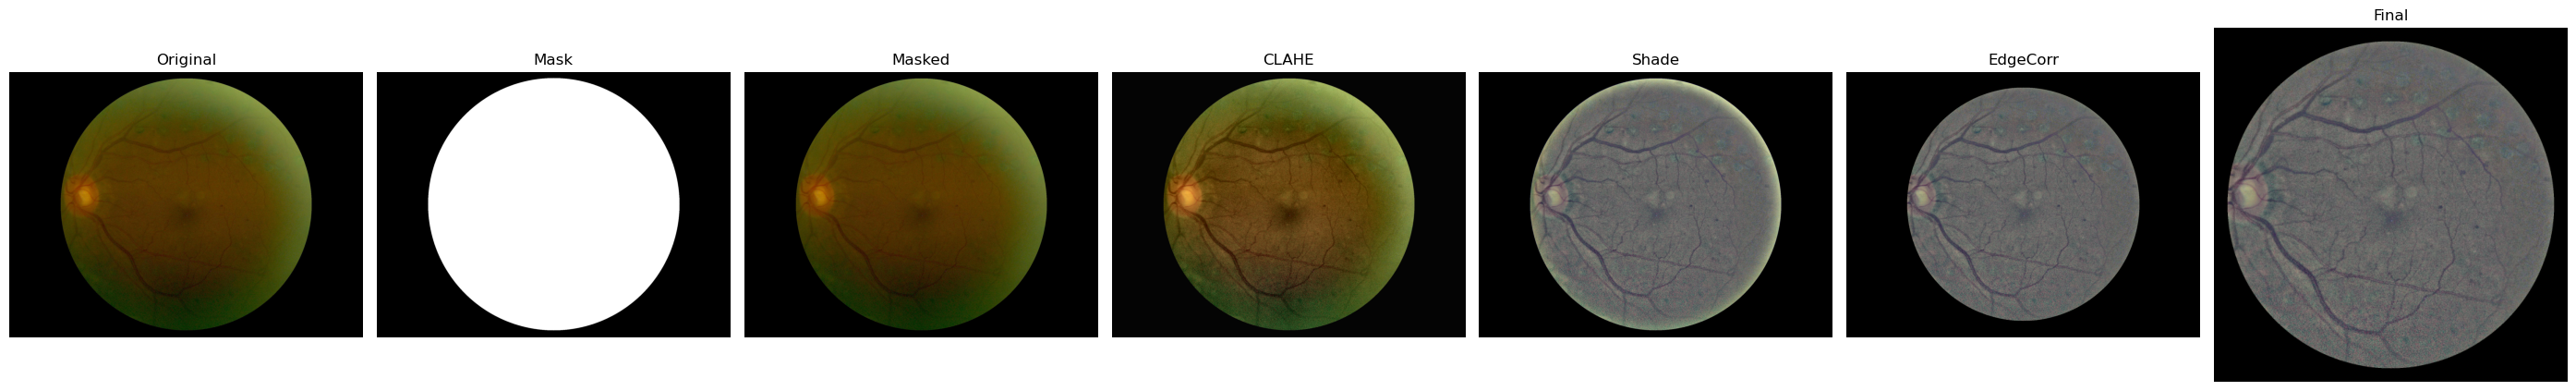

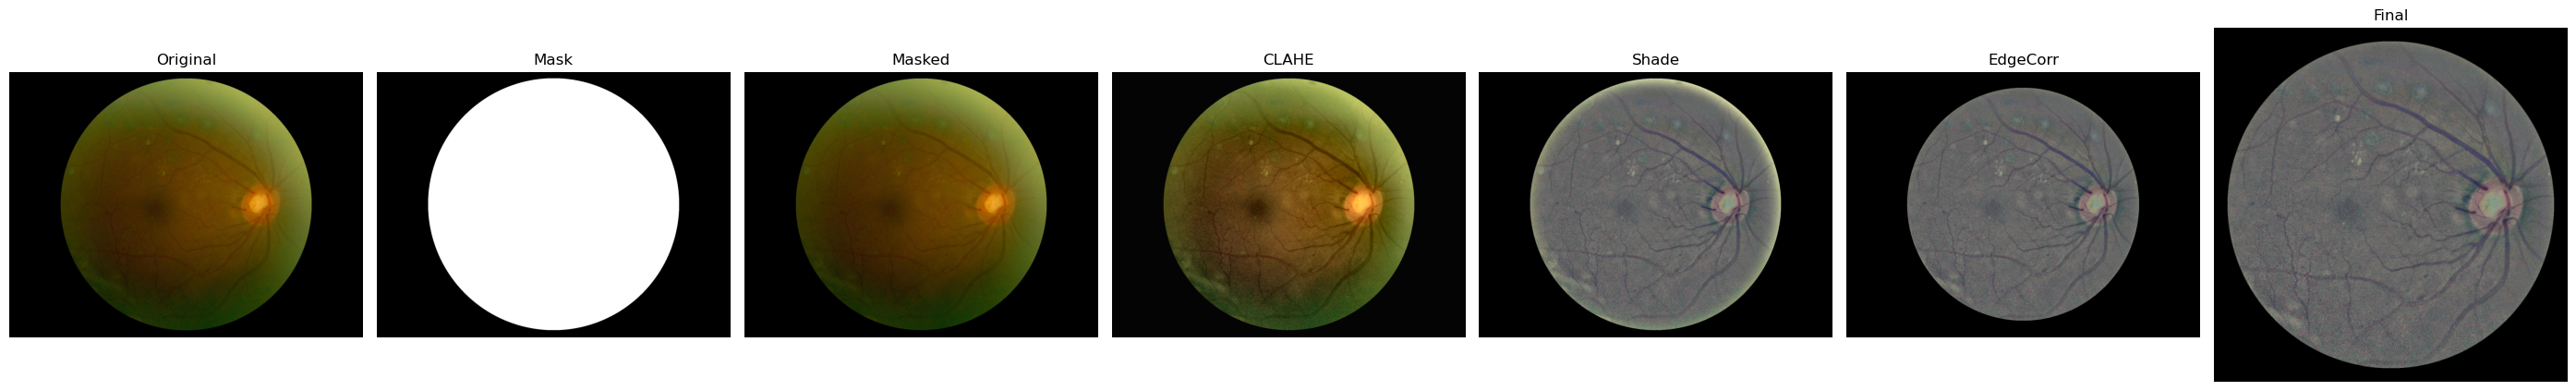

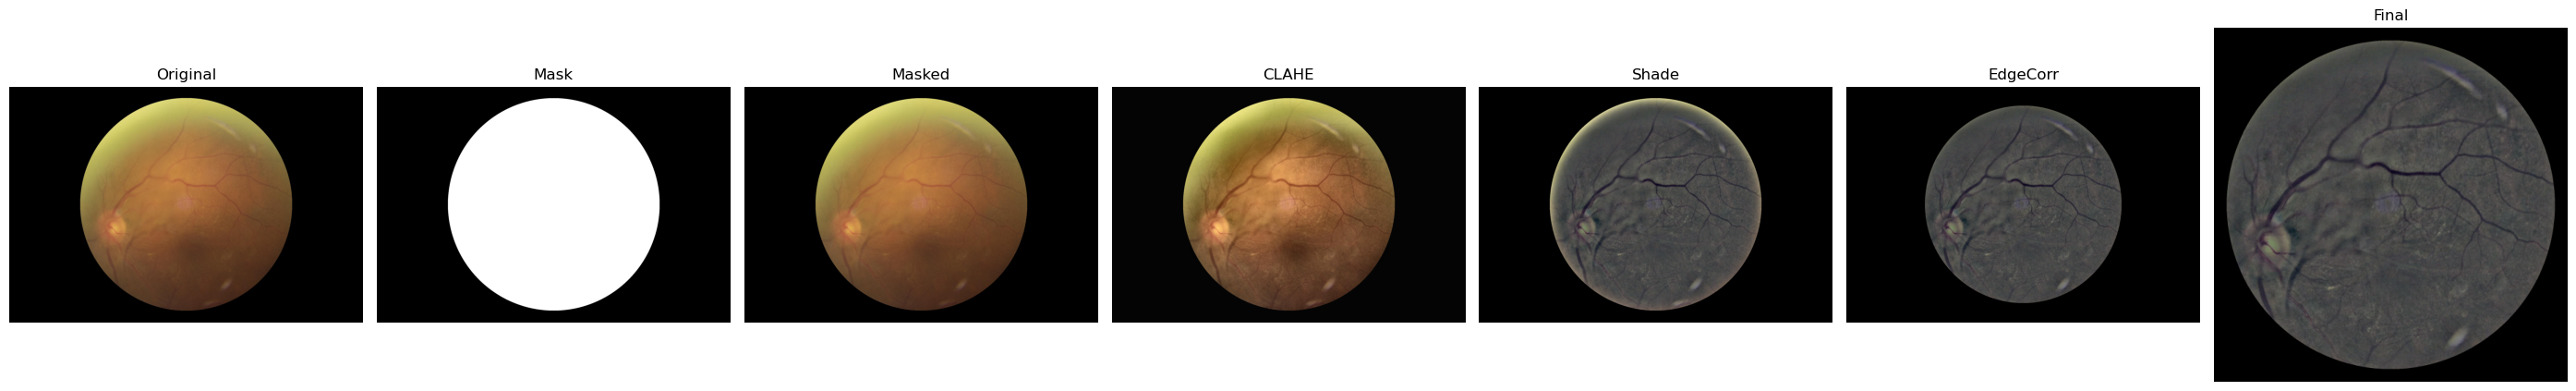

Visualizing samples for On-site Test Set


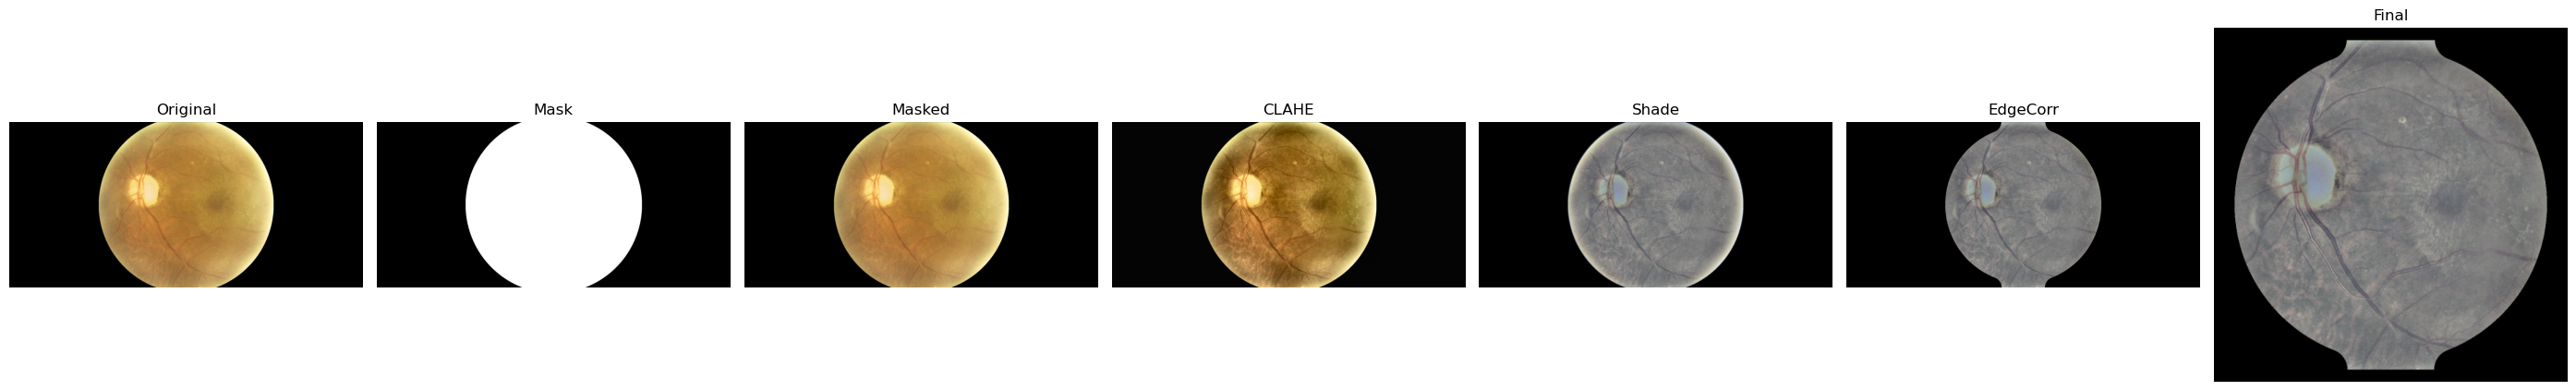

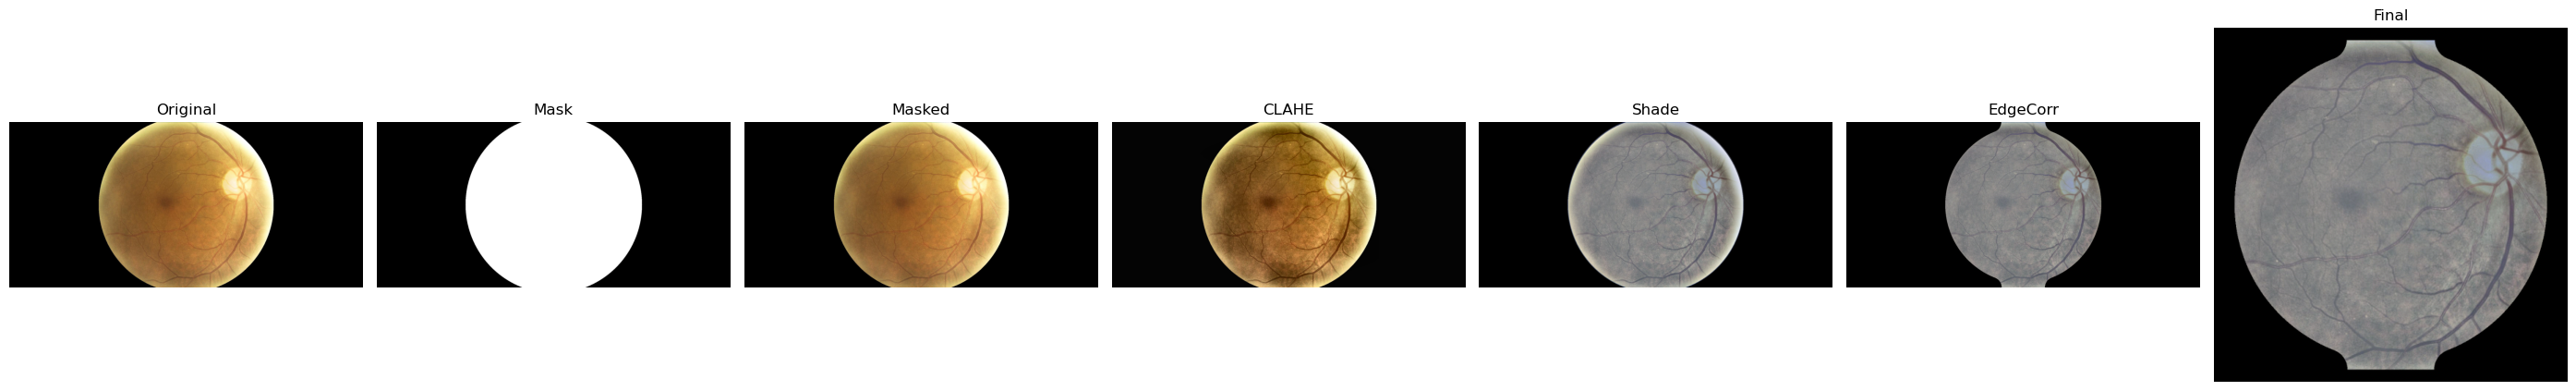

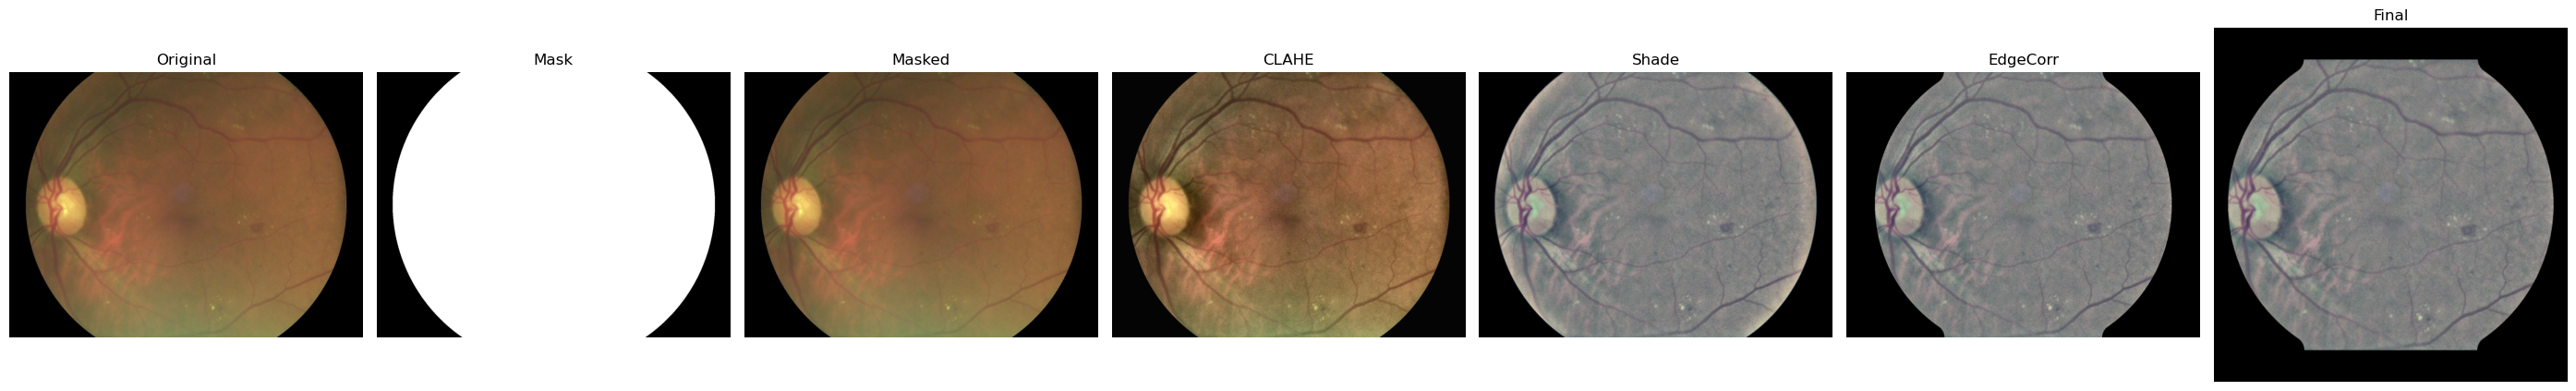

In [ ]:
# Settings 
ROOT = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR")
OUT_ROOT = ROOT.parent / f"{ROOT.name}-pre-2"
TARGET_SIZE = (512, 512)         # (H, W)
CLAHE_CLIP  = 2.0
CLAHE_GRID  = 8
GAUSS_SIGMA = 40
SAMPLE_COUNT = 3  # number of samples to visualize per split

# Visualization for All Splits
for split in ['Training Set', 'Off-site Test Set', 'On-site Test Set']:
    print(f"Visualizing samples for {split}")
    img_dir = ROOT / split / 'Images'
    for img_path in sorted(img_dir.glob('*.jpg'))[:SAMPLE_COUNT]:
        show_sample_pipeline(img_path)


In [ ]:
# Batch Processing
rim_width = 55  

for split in ['Training Set', 'Off-site Test Set', 'On-site Test Set']:
    img_dir = ROOT / split / 'Images'
    out_img = OUT_ROOT / split / 'images'
    ensure(out_img)
    print(f"Processing all images for {split}")

    def process(img_path: Path):
        # 1. read & extract circular mask
        img_bgr = cv2.imread(str(img_path))
        mask    = extract_circular_mask(img_bgr)

        # 2. background masking + CLAHE + shading
        img_f = to_float(img_bgr)
        img_f[~mask.astype(bool)] = 0.0
        img_f = clahe_rgb_float(img_f)
        img_f = shade_correct_gauss(img_f, mask)

        # 3. ring darkening (edge correction)
        kern  = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, 
            (2*rim_width + 1, 2*rim_width + 1)
        )
        inner = cv2.erode(mask, kern)
        ring  = mask.astype(bool) & ~inner.astype(bool)
        # zero out that ring
        img_f[ring] = 0.0

        # 4) Crop, resize, and save
        img_crop = crop_pad_square(img_f, mask)
        final    = cv2.resize(
            img_crop,
            (TARGET_SIZE[1], TARGET_SIZE[0]),
            interpolation=cv2.INTER_AREA
        )
        cv2.imwrite(str(out_img / f"{img_path.stem}.png"), to_uint8(final))

    list(tqdm(
        ThreadPoolExecutor().map(process, sorted(img_dir.glob('*.jpg'))),
        total=len(list(img_dir.glob('*.jpg')))
    ))

print("Pre-processing complete.")

Processing all images for Training Set


100%|██████████| 7000/7000 [1:18:07<00:00,  1.49it/s]  


Processing all images for Off-site Test Set


100%|██████████| 1000/1000 [11:33<00:00,  1.44it/s]


Processing all images for On-site Test Set


100%|██████████| 2000/2000 [22:49<00:00,  1.46it/s]

Pre-processing complete.


# Further Pre-procssing for black backgrounds

In [ ]:
def preprocess_fundus(img: Image) -> Image:
    """
    Mask everything outside the fundus to black by fitting a circle around the largest contour.
    """
    arr = np.array(img)
    # convert to grayscale and threshold (Otsu) to isolate retina
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # close small holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # find largest contour (fundus)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        # fit minimum enclosing circle
        (x, y), r = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(r)
        # create circular mask
        mask = np.zeros_like(gray)
        cv2.circle(mask, center, radius, 255, -1)
        # apply mask to all channels
        mask3 = np.stack([mask] * 3, axis=-1)
        arr[mask3 == 0] = 0
    return Image.fromarray(arr)

In [ ]:
# Batch Background Preprocessing
# Set paths
dataset_dir = Path(r"C:/Users/ioana/Documents/VS Projects/Quantitative-Big-Immaging-Project/Datasets/OIA-ODIR-pre")
output_dir = Path(r"C:/Users/ioana/Documents/VS Projects/Quantitative-Big-Immaging-Project/Datasets/OIA-ODIR-pre-BlackBG")

splits = ['Training Set', 'On-site Test Set', 'Off-site Test Set']

for split in splits:
    img_dir = dataset_dir / split / 'Images'
    split_out = output_dir / split / 'Images_BlackBG'
    split_out.mkdir(parents=True, exist_ok=True)
    print(f"Processing {split}: {len(list(img_dir.glob('*.*')))} images")
    for img_path in tqdm(sorted(img_dir.glob('*.*'))):
        try:
            img = Image.open(img_path).convert("RGB")
            black_bg = preprocess_fundus(img)
            black_bg.save(split_out / img_path.name)
        except Exception as e:
            print(f"Failed {img_path.name}: {e}")

print("Background masking complete. Saved to", output_dir)

Processing Training Set: 7000 images


100%|██████████| 7000/7000 [00:56<00:00, 124.26it/s]


Processing On-site Test Set: 2000 images


100%|██████████| 2000/2000 [00:25<00:00, 77.64it/s]


Processing Off-site Test Set: 1000 images


100%|██████████| 1000/1000 [00:12<00:00, 78.95it/s]

Background masking complete. Saved to C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-BlackBG
